## Credit Risk Model

#### Importing necessary libraries

In [17]:
import os
import sys
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [18]:
sys.path.append(os.path.abspath('../scripts'))

from Utils import DataUtils
from Plotting import Plots

data_utils = DataUtils()
plotting = Plots()

#### RFMS

In [19]:
# Read specific version of data where you added the features
filepath = '../data/data.csv'

data = data_utils.load_data(filepath)
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])

2024-10-07 23:02 - DEBUG :: Loading data from file...


In [24]:
# RFM: R- recency
recent_date = data['TransactionStartTime'].max()
data['Recency'] = data['TransactionStartTime'].apply(lambda x: (recent_date - x).days)

In [8]:
# RFM: F- Frequency
frequency_data = data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency_data.rename(columns={'TransactionId': 'Frequency'}, inplace=True)
data = data.merge(frequency_data, on='CustomerId', how='left')

In [74]:
# RFM: M- Monetory
col = 'Total_transaction_amount'  # The column for the monetory part has already been calculated

In [25]:
RFM_data = data[['CustomerId','Recency', 'Frequency', 'Total_transaction_amount']]
RFM_data = RFM_data.rename({'Total_transaction_amount': 'Monetary'}, axis=1)
RFM_data.head()

,CustomerId,Recency,Frequency,Monetary
0,2584,90,119,109921.75
1,2584,90,119,109921.75
2,2806,90,2,1000.00
3,3733,90,38,228727.20
4,3733,90,38,228727.20


#### Ranking Customer’s based upon their recency, frequency, and monetary score

In [26]:
RFM_data['R_rank'] = RFM_data['Recency'].rank(ascending=False)
RFM_data['F_rank'] = RFM_data['Frequency'].rank(ascending=True)
RFM_data['M_rank'] = RFM_data['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
RFM_data['R_rank_norm'] = (RFM_data['R_rank']/RFM_data['R_rank'].max())*100
RFM_data['F_rank_norm'] = (RFM_data['F_rank']/RFM_data['F_rank'].max())*100
RFM_data['M_rank_norm'] = (RFM_data['F_rank']/RFM_data['M_rank'].max())*100
 
RFM_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
RFM_data.head()

,CustomerId,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,2584,90,119,109921.75,0.120398,56.718331,55.538936
1,2584,90,119,109921.75,0.120398,56.718331,55.538936
2,2806,90,2,1000.00,0.120398,1.028125,1.006747
3,3733,90,38,228727.20,0.120398,29.066836,28.462424
4,3733,90,38,228727.20,0.120398,29.066836,28.462424


#### Calculating RFM score

- Since we are calculating RFM Score for credit risk model we will give the monetary value the highest weight.
- We will also give the frequency value more weight compared to the recency value
- Formula for calculating RFM socre = `0.15*Recency score + 0.25*Frequency score + 0.60 *Monetary score`
- And we will cluster the RFM score to 2 clusters

In [27]:
RFM_data['RFM_Score'] = (0.15 * RFM_data['R_rank_norm'] +
                     0.25 * RFM_data['F_rank_norm'] +
                     0.60 * RFM_data['M_rank_norm'])

2024-10-06 10:54 - DEBUG :: locator: <matplotlib.ticker.AutoLocator object at 0x000001AA36273C20>


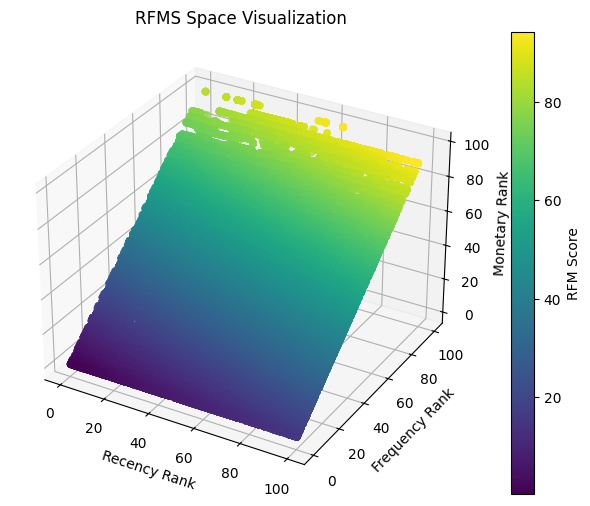

In [111]:
plotting.RFM_Space_visualization(RFM_data)

**Observation**
- From the plot we can segemnt the costomers as good or bad would likely be between the green area. Since this is hard to quantify we will use k-means clustering to label the customers

In [28]:
kmeans = KMeans(n_clusters=2)
RFM_data['Cluster'] = kmeans.fit_predict(RFM_data[['RFM_Score']])


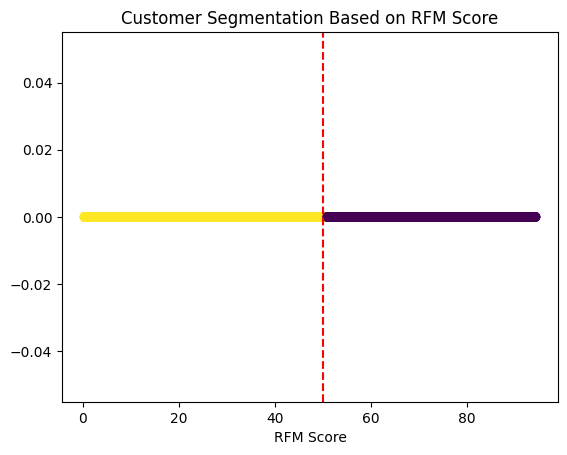

In [29]:
# Assuming Bati bank has more resources to lend we can label them half way based on the RFM 'score
plt.scatter(RFM_data['RFM_Score'], [0]*len(RFM_data), c=RFM_data['Cluster'])
plt.xlabel('RFM Score')
plt.title('Customer Segmentation Based on RFM Score')
plt.axvline(x=RFM_data['RFM_Score'].median(), color='red', linestyle='--', label='Centroid 1')   
plt.show()

**Assumption**
- Bati bank has more resources to lend we can label them half way based on the RFM score. So that any resource won't be left out without being allocated

In [30]:
kmeans.cluster_centers_

array([[71.7539352 ],
       [29.33518693]])

**Observation**
- We can see that the cluster centers are `71.7` so for every value that has RFM_Score greater that 71.7 will be labeled as good and the rest will be labeled bad
    * Good = 1
    * Bad = 0
- This is done assuming that bati bank has less resources and want to effectively classify the customers more thourouly. 
- But if Bati bank has more resources and would like to lend them or utilize them effectively the above plot can be used as a way to classify the customers

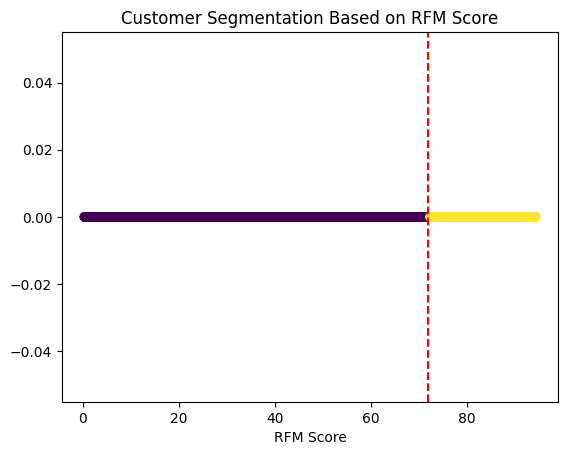

In [31]:
# Assuming Bati bank has less resource to allocate
plt.scatter(RFM_data['RFM_Score'], [0]*len(RFM_data), c=RFM_data['RFM_Score'].apply(lambda x: 1 if x > kmeans.cluster_centers_[0][0] else 0))
plt.xlabel('RFM Score')
plt.title('Customer Segmentation Based on RFM Score')
plt.axvline(x=kmeans.cluster_centers_[0][0], color='red', linestyle='--', label='Centroid 1')   
plt.show()

**Assumption**
- Bati bank has less resource to allocate

**Analysis**
- Which type of labelling method to use should be decided with management

In [36]:
RFM_data['Cluster'] = RFM_data['RFM_Score'].apply(lambda x: 1 if x > kmeans.cluster_centers_[0][0] else 0)
RFM_data.rename({'Cluster' : 'RiskResult'}, axis=1, inplace=True)
RFM_data_separate = RFM_data['RiskResult']

data_merged = pd.concat([data, RFM_data_separate], axis=1)
data_merged.to_csv('../data/data.csv', index=False), # saved using dvc

(None,)